# MultiScaleFractionalGenerator example

In this example, the fluctuation function is given by two asymptotes, with slopes H1 at small scales (high frequencies) and H0 at large scales (low frequencies), with a point of convergence in Sx.

The output displays the specified asymptotes (dotted lines) and the empirical FF (in red).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from StatTools.analysis.dpcca import dpcca
from StatTools.generators.multi_scale_fractional_generator import (
    MultiScaleFractionalGenerator,
)


In [2]:
n_tracks = 8
length = 2**16
h_list = [0.8, 1.5]  # [H0, H1]
crossover_points = [2**3]  # [Sx]

In [3]:
gen = MultiScaleFractionalGenerator(h_list=h_list, crossover_points=crossover_points)
signals = gen.generate(length, n_tracks)

In [4]:
S = 2 ** np.arange(3, int(np.log2(length)) + 1)
step = 0.5
threads = 4

p1, r1, f1, s1 = dpcca(signals, 2, step, S, processes=threads, n_integral=1)

	DPCAA warning: only following S values are in use: [np.int64(8), np.int64(16), np.int64(32), np.int64(64), np.int64(128), np.int64(256), np.int64(512), np.int64(1024), np.int64(2048), np.int64(4096), np.int64(8192), np.int64(16384)]


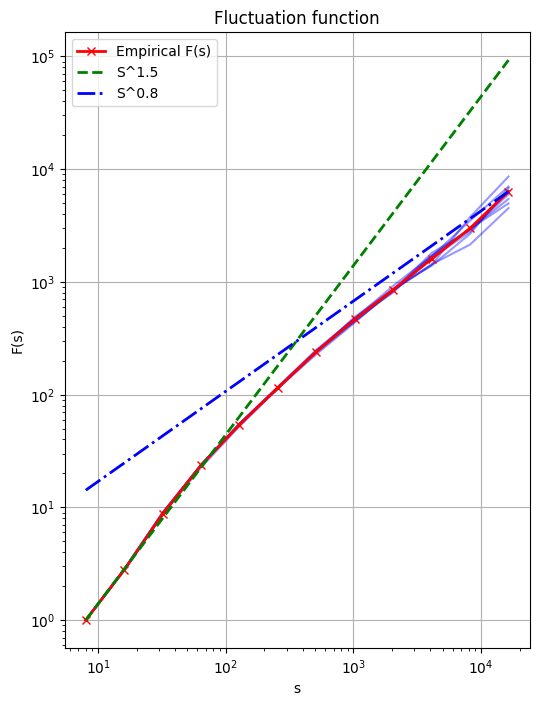

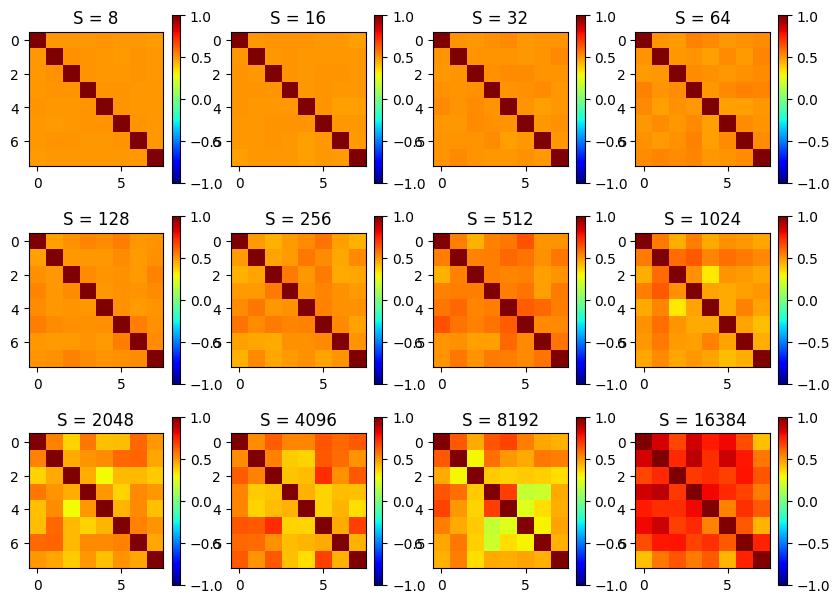

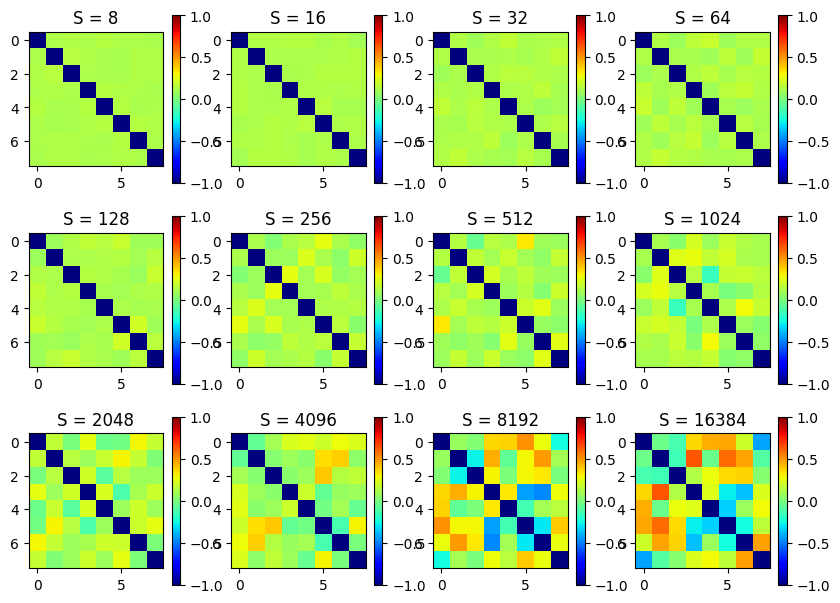

In [5]:
F = np.transpose(f1, (1, 2, 0))
F0 = F * np.eye(F.shape[0])[:, :, None]
F0[F0 == 0] = np.nan

# The average FF on the diagonal
Fs_ave = np.sqrt(np.nanmean(F0, axis=(0, 1)))
Fs_ave /= Fs_ave[0]
S = S[0 : len(Fs_ave)]
plt.figure(figsize=(6, 8))

for i in range(F.shape[0]):
    for j in range(F.shape[1]):
        if i != j:
            continue
        plt.loglog(S, np.sqrt(F[i, j, :] / F[i, j, 0]), alpha=0.4, color="b")

plt.loglog(S, Fs_ave, "rx-", linewidth=2, label="Empirical F(s)")
plt.loglog(
    S, S ** h_list[1] / S[0] ** h_list[1], "g--", linewidth=2, label=rf"S^{h_list[1]}"
)
plt.loglog(
    S,
    S ** h_list[0] / S[-1] ** h_list[0] * Fs_ave[-1],
    "b-.",
    linewidth=2,
    label=f"S^{h_list[0]}",
)
plt.xlabel("s")
plt.ylabel("F(s)")
plt.legend()
plt.title("Fluctuation function")
plt.grid(True)

plt.figure(figsize=(10, 10))
for i in range(len(S)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(r1[i, :, :], vmin=-1, vmax=1, cmap="jet")
    plt.colorbar()
    plt.title(f"S = {S[i]}")

plt.figure(figsize=(10, 10))
for i in range(len(S)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(p1[i, :, :], vmin=-1, vmax=1, cmap="jet")
    plt.colorbar()
    plt.title(f"S = {S[i]}")

plt.show()